## Analyse A/B Test Results
by Anas A. Mohaisin

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [4]:
import pandas as pd
import numpy as np
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [5]:
folder_name='mydata'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [6]:
df=pd.read_csv('./mydata/ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

<div class="alert alert-block alert-success">
There are 294478 rows
</div>

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

<div class="alert alert-block alert-success">
       There are 290584 unique users
</div>

d. The proportion of users converted.

In [6]:
(len(df[df['converted']==True]))/df.shape[0]

0.11965919355605512

<div class="alert alert-block alert-success">
    
The approximate proportion of converted users is 12% approx.
    
</div>

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.query("(group == 'treatment' and landing_page == 'old_page') | (group == 'control' and landing_page == 'new_page')")

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
...,...,...,...,...,...
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294252,892498,2017-01-22 01:11:10.463211,treatment,old_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


<div class="alert alert-block alert-success">
There are 3893 times that treatment group and new page do not lineup.
</div>

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

<div class="alert alert-block alert-success">
    
There is no null values.
    
</div>

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

In [4]:
mysql=df.query('(group == "treatment" and landing_page != "new_page") | (group != "treatment" and landing_page == "new_page") | (group == "control" and landing_page != "old_page") | (group != "control" and landing_page == "old_page")')
df2=df.drop(mysql.index)

In [5]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

<div class="alert alert-block alert-success">
Droping 3893 rows where reatment group and new page do not lineup
</div>

`3.` Use **df2**

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique(),df2.shape

(290584, (290585, 5))

<div class="alert alert-block alert-success">
There are 290584 unique users
</div>

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2['user_id'][df2.duplicated(['user_id'], keep=False)]

1899    773192
2893    773192
Name: user_id, dtype: int64

<div class="alert alert-block alert-success">
Index 1899 and 2893 show that user ID 773192 is repeated twice.
</div>

c. What is the row information for the repeat **user_id**? 

In [6]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


<div class="alert alert-block alert-success">
Repeatd user ID 773192 belongs to the treatment group who landed new page and is non-converted.
</div>

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [7]:
df2.drop_duplicates(subset=['user_id'],inplace=True)
sum(df2['user_id'].duplicated())

0

`4.` Use **df2**

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df.query('converted==True').shape[0]/df['converted'].shape[0]

0.11965919355605512

<div class="alert alert-block alert-success">
The probability for being converted is 11.95%; i.e.  
$P(converted = True)=0.1195$
</div>

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

<div class="alert alert-block alert-success">
    
The probability for being converted given an individual belongs to the control group is 12%;\
i.e. $P(converted = True|control group)=0.12$
    
</div>

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group=="treatment"')['converted'].mean()

0.11880806551510564

<div class="alert alert-block alert-success">
    
The probability for being belonging to the treatment group given converted is 11.88%;\
i.e. $P(converted=True|treatment group)=0.1188$

</div>

d. What is the probability that an individual received the new page?

In [18]:
(df2.landing_page=='new_page').mean()

0.5000619442226688

<div class="alert alert-block alert-success">
The probability for an individual for landnding a new page is 50%; i.e.
$P(landing page=new page)=0.05$
</div>

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**
<div class="alert alert-block alert-success">
The probability for being converted given that the individual belong to the treated or controlled groups, shows no difference (very slight difference) 11.8% and 12%, respectively. On the other hand, the probability for individual who receives a new page is 50% which means that the probability to receive an old page is 50% too
$P(\neg New page)=(New page)=0.5$
Therefore, there is no sufficient evidence that the treatment leads to more conversions.
</div>


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
<div class="alert alert-block alert-success">

$H_0: p_{new} \leq p_{old}\\
H_a: p_{new} > p_{old}$
    
1. Null Hypothsis: New page is similar or less then old page.
2. Alternate Hypothsis: New page is better than the old page.    
</div>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem. <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new=(len(df2[df2['converted']==True]))/df2.shape[0]
p_new

0.11959708724499628


<div class="alert alert-block alert-success">
converted rate is 11.9 for the new page
</div>

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old=(len(df2[df2['converted']==True]))/df2.shape[0]
p_old

0.11959708724499628

<div class="alert alert-block alert-success">
converted rate is 11.9 for the old page.
</div>

c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page"').user_id.nunique()
n_new

145310

<div class="alert alert-block alert-success">
Number of users who land the new page is 145310
</div>

d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page"').user_id.nunique()
n_old

145274

<div class="alert alert-block alert-success">
Number of users who land old pages is 145275
</div>

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new
new_page_converted

array([0.12032895, 0.11875301, 0.1189457 , ..., 0.11937238, 0.11955819,
       0.11983346])

<div class="alert alert-block alert-success">
Simulate a uniform random sample, size = 145310 , $P(0.119,(1-0.119) = 0.881$
</div>

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old
old_page_converted

array([0.11894076, 0.12066853, 0.12029682, ..., 0.11985627, 0.11962223,
       0.11908531])

<div class="alert alert-block alert-success">
Simulate a uniform random sample, size = 145274 , $P(0.119,(1-0.119) = 0.88$
</div>

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted-new_page_converted


array([0., 0., 0., ..., 0., 0., 0.])

<div class="alert alert-block alert-success">
    
The difference between observed simulated mean is 0
    
</div>

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new
    old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old
    p_diffs = new_page_converted - old_page_converted
    p_diffs

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

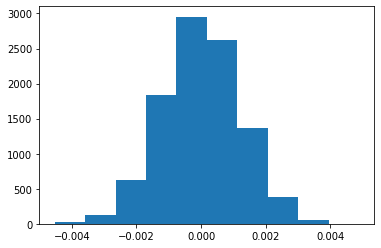

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

0.9056

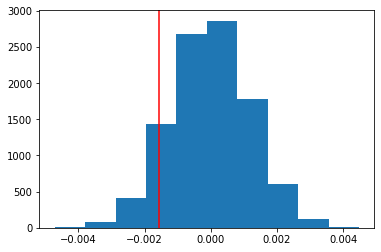

In [28]:
p_diffs = np.array(p_diffs)
obs_diff=df2.query('group=="treatment"')['converted'].mean()-df2.query('group=="control"')['converted'].mean()
null_val=np.random.normal(0,p_diffs.std(),p_diffs.size)

plt.hist(null_val)
plt.axvline(x=obs_diff,color='r'); (null_val>obs_diff).mean()

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<div class="alert alert-block alert-success">
    
1.We have drawn a sample for guassian distibution where $ \sim \mathcal{N}(0,\sigma^2)$ to find the p-value.\
2. It is the p-value. It is the statistical sigfinicance level which represents the rejection area $\alpha$ where accept the $H_0$ if the P-value $> \alpha$ or fail to accept the $H_0$ if P-value $< \alpha$.\
3. Clearly, we accept the $H_0$ at statistical sigificance level $\alpha=0.05$
    
</div>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
stat, pval =sm.stats.proportions_ztest([convert_old, convert_new], \
                                       [n_old, n_new],alternative='smaller')
stat,pval

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<div class="alert alert-block alert-success">
    
In z-score we bring our data around the mean value. So, we agree with **j.** and **k.** as P-value in ~ 0.90 where we accept the $H_0$?
</div>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

It is a **logistic regression model** where:
$
y_i= 
\begin{cases}
   1, &\text{if } {y_i}^\ast \geq 0\\
   0, &\text{if } {y_i}^\ast <0\\
\end{cases}
$

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2[['new_page','old_page']]=pd.get_dummies(df2['landing_page'])
df2[['treatement','ab_page',]]=pd.get_dummies(df2['group'])
df2['intercept']=1
df2.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page,treatement,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
import statsmodels.api as sm;
logit_m=(sm.Logit(df2['converted'],df2[['intercept','ab_page']])).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
logit_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Nov 2020   Pseudo R-squ.:               8.077e-06
Time:                        16:07:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

<div class="alert alert-block alert-success">

1. Two-tailed P-value in the regression model used in testing the $H_0$ that the coefficient (parameter) is 0 at a pre-selected statisical significance level $\alpha$. E.g. if coefficient value $x_i$ is less than or equal  $\alpha \leq 0.05$, then we fail to accept the $H_0$: $x_i$ is significantly different from 0.\
2. One-tailed P-Value in **Part II**, using in testing the $H_0$ that the difference in mean between the two groups (treatment & contorl) is 0 i.e. $H_0{:}  \mu=\mu_0 \textit{ vs } H_a{:} \mu \neq \mu_0$.

</div>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<div class="alert alert-block alert-success">

Consider other variables is related to model identification which can not be arbitrary. Model can be just-identified, over-identified, or under-indentified.
From a mathematical standpoint, if we add one or more variables, we may have high value for $R^2$ but ${\mathbb E}(x_i,\epsilon) \neq 0$, where error term is correlated with Age or Eduction i.e. endogenity. Or measurement error in $x_i$ where the parameters are biased downward. Conversely, if we drop/don't add one or more variable then it is an omitted variable problem where the parameters are biased upward.
Therefore, model should be just-identified where parameters are unique.\
E.g. If we add the Education level variable for an individual who may convert or not. The question is: what if an individual's Education Level is affected by mother/father's Eduction level!

    
</div>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df_new.head()

,country,timestamp,group,landing_page,converted,new_page,old_page,treatement,ab_page,intercept
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,0,1,1


In [35]:
### Create the necessary dummy variables
ls_country = list(set(df_new['country']))
ls_country

['CA', 'UK', 'US']

In [36]:
df_new[['US','CA','UK']]=pd.get_dummies(df_new['country'])
df_new=df_new.drop('US', axis=1)
#df_new.head()
logit_m=(sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK']])).fit()
logit_m.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Nov 2020   Pseudo R-squ.:               2.323e-05
Time:                        16:07:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA             0.0506      0.028      1.784      0.074      -0.005       0.106
UK             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [37]:
np.exp(-0.0149),np.exp(0.0506),np.exp(0.0408)

(0.9852104557227469, 1.0519020483004984, 1.0416437559600236)

<div class="alert alert-block alert-success">

Using the odd-ratio to interpret the coeficients where **none of them are statistically significant at $\alpha = 0.05$ et ceteris paribus**:
1. An increase in landed_page by one new page, it is 98 percentage point less likely to convert.
2. In Canada, indvidual is 1.05 more likely to convert comparing to the US indvidual.
3. In the UK, indvidual is 1.04 more likely to convert comparing to the US indvidual.
    
Spatial coefficients for the UK and Canada show a very slight difference among them. Still, there is a negative impact of the increase in landing page on an individual(s) to convert.

</div>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,new_page,old_page,treatement,ab_page,intercept,CA,UK,UK_ab_page,CA_ab_page
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,0,1,1,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,0,1,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,0,1,1,1,0,0,1


In [39]:
### Fit Your Linear Model And Obtain the Results
import statsmodels.formula.api as smf
logit_m=(sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK','CA_ab_page','UK_ab_page']])).fit()
logit_m.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Nov 2020   Pseudo R-squ.:               3.482e-05
Time:                        16:07:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
CA             0.0118      0.040      0.296      0.767      -0.066       0.090
UK             0.0175      0.038      0.465      0.642      -0.056       0.091
CA_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
UK_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [40]:
np.exp(-0.0674),np.exp(0.0118),np.exp(0.0175),np.exp(0.0783),np.exp(0.0469)

(0.9348211980618836,
 1.011869894648401,
 1.0176540221507617,
 1.0814470441230692,
 1.048017202119183)

<a id='conclusions'></a>
## Conclusions

<div class="alert alert-block alert-success">

Using the odd-ratio to interpret the coeficients where **none of them are statistically significant at $\alpha=0.05$ et ceteris paribus**:
1. An increase in landed_page by one new page, it is 93 percentage point less likely to convert.
2. In Canada, indvidual is 1.011 more likely to convert comparing to the US indvidual.
3. In the UK indvidual is 1.017 more likely to convert comparing to the US individual
4. Individual in CA is 1.081 more likely to interact with pages comparing to the US indvidual.
5. Individual in the UK is 1.048 more likely to interact with pages comparing to the US indvidual.

Different dimemssion (spatial) and different technique (regression) show no difference in responses.

**Since the new page does not motivate individuals to use it, the decision-maker(s) has no incentive to spend on the new page.**
Responses 
    
</div>

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyse_ab_test_results_notebook.ipynb'])

0